# **Creating a Cat vs Dog Classifier**
Using InceptionV3 network, freezing the conv layers and training only linear Dense layers

**Check Tensorflow Version**

In [1]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

**Set drive**

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


**Download Data and store in working directory over drive**

In [6]:
import zipfile
import urllib.request


data_url = "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip"
data_file_name = "catsdogs.zip"
download_dir = '/content/drive/My Drive/Colab Notebooks/AdvancedComputerVisionCoursera/Week1/'
urllib.request.urlretrieve(data_url, data_file_name)
zip_ref = zipfile.ZipFile(data_file_name, 'r')
zip_ref.extractall(download_dir)
zip_ref.close()



In [8]:
import os

print("Number of cat images:",len(os.listdir('/content/drive/My Drive/Colab Notebooks/AdvancedComputerVisionCoursera/Week1/PetImages/Cat/')))
print("Number of dog images:", len(os.listdir('/content/drive/My Drive/Colab Notebooks/AdvancedComputerVisionCoursera/Week1/PetImages/Dog/')))


Number of cat images: 12501
Number of dog images: 12501


**Create data directory as needed to train our model**

In [10]:
import sys
path = '/content/drive/My Drive/Colab Notebooks/AdvancedComputerVisionCoursera/Week1/'
try:
  os.mkdir(os.path.join(path,'cats-v-dogs'))
  os.mkdir(os.path.join(path,'cats-v-dogs/training'))
  os.mkdir(os.path.join(path,'cats-v-dogs/testing'))
  os.mkdir(os.path.join(path,'cats-v-dogs/training/cats'))
  os.mkdir(os.path.join(path,'cats-v-dogs/training/dogs'))
  os.mkdir(os.path.join(path,'cats-v-dogs/testing/cats'))
  os.mkdir(os.path.join(path,'cats-v-dogs/testing/dogs'))
except OSError:
  pass

**Copy downloaded data by shuffling it and dividing it into train and test sets**

In [15]:
import random
from shutil import copyfile
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[training_length:]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)


CAT_SOURCE_DIR = path +"/PetImages/Cat/"
TRAINING_CATS_DIR = path+"/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = path+"/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = path+"/PetImages/Dog/"
TRAINING_DOGS_DIR = path+"/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = path+"/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


In [17]:
print("Number of training cat images", len(os.listdir(path+'/cats-v-dogs/training/cats/')))
print("Number of training dog images", len(os.listdir(path+'/cats-v-dogs/training/dogs/')))
print("Number of testing cat images", len(os.listdir(path+'/cats-v-dogs/testing/cats/')))
print("Number of testing dog images", len(os.listdir(path+'/cats-v-dogs/testing/dogs/')))

Number of training cat images 11250
Number of training dog images 11250
Number of testing cat images 1250
Number of testing dog images 1250


**Define Train and Validation image data generators**

Also apply some transforms to the data when generating a batch

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


TRAINING_DIR = path+'/cats-v-dogs/training/'

train_data_gen = ImageDataGenerator(rescale=1/255.,
                                      rotation_range=40,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      fill_mode='nearest'
                                     )


train_generator = train_data_gen.flow_from_directory(TRAINING_DIR,
                                                     target_size=(150,150),
                                                     class_mode='binary',
                                                     batch_size=100)

VALIDATION_DIR = path+'/cats-v-dogs/testing/'
val_data_gen = ImageDataGenerator(rescale=1/255.)

val_generator = val_data_gen.flow_from_directory(VALIDATION_DIR,
                                                  target_size=(150,150),
                                                  class_mode='binary',
                                                  batch_size=100)




Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


**Download InceptionV3 weights, fetch imagenet pretrained InceptionV3 and freeze its layers**

In [24]:
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3

weights_url = "https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
weights_file = "inception_v3.h5"
urllib.request.urlretrieve(weights_url, weights_file)

pretrained_model = InceptionV3(weights='imagenet',
                               input_shape=(150,150,3),
                               include_top=False)

pretrained_model.load_weights(weights_file)

for layer in pretrained_model.layers:
  layer.trainable = False

pretrained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 74, 74, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 74, 74, 32)   96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 74, 74, 32)   0           batch_normalization_188[0][0]    
_______________________________________________________________________________________

**Get output of last convolutional layer**

In [28]:
last_kayer = pretrained_model.get_layer('mixed7')
last_layer_shape = last_layer.output_shape
last_output = last_layer.output
last_layer_shape

(None, 7, 7, 768)

**Flatten and add Dense layers to final prediction**

In [30]:
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras import Model

x = Flatten()(last_output)
x = Dense(1024,activation='relu')(x)
x = Dense(1,activation='sigmoid')(x)

model = Model(pretrained_model.input,x)

**Compile and Train Model with RMSProp**

In [33]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(
            train_generator,
            validation_data=val_generator,
            epochs=2,
            verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/2
 35/225 [===>..........................] - ETA: 13:24 - loss: 0.5141 - acc: 0.8457

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

225/225 [==============================] - 1069s 5s/step - loss: 0.2369 - acc: 0.9104 - val_loss: 0.0927 - val_acc: 0.9636
Epoch 2/2
225/225 [==============================] - 1077s 5s/step - loss: 0.1482 - acc: 0.9374 - val_loss: 0.1144 - val_acc: 0.9584


**Plotting training and validation accuracies**

<Figure size 432x288 with 0 Axes>

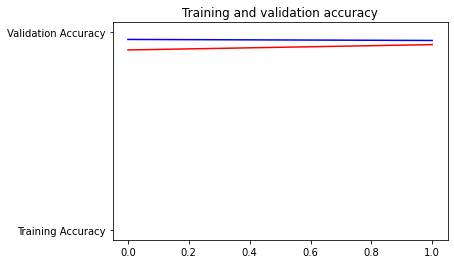

<Figure size 432x288 with 0 Axes>

In [41]:

train_acc = history.history['acc']
val_acc = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

%matplotlib inline
import matplotlib.image  as mpimg
from matplotlib import pyplot as plt

epochs = range(len(train_acc))


plt.plot(epochs, train_acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()


**Browse an image and use model for predicition**

In [42]:

import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  image_tensor = np.vstack([x])
  classes = model.predict(image_tensor)
  print(classes)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")

Saving corgi.jpg to corgi.jpg
[[1.]]
[1.]
corgi.jpg is a dog
